In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob 
from plotly.subplots import make_subplots
from datetime import datetime


## 💾 Carga de Datos

In [2]:
def data_upload():
    csv_files = glob.glob('./Cambridge_csv/*.csv')
    mean_altitude = np.zeros([1, 117])
    #Obtaining the mean trajectory information
    for file in csv_files:mean_altitude += np.array(pd.read_csv(file)['altitude'])
    mean_altitude = mean_altitude / len(csv_files)
    # Converting to Dataframe
    Data = pd.DataFrame(mean_altitude.T, columns=['altitude'])
    Data.index = range(1, len(Data) + 1)
    return Data

## 🌍 Variables Físicas

In [3]:
def alt_tmp(z):
    # The altitude value must be in [m]
    if (z<11019):
        z0,T0,lambda0,P0 = (0,288.15,-0.0065,101325.0)
        return T0 + lambda0 * (z - z0)

    elif (z<20063):
        z0,T0 = (11019,216.65)
        return T0 

    elif (z < 32162):
        z0,T0,lambda0,P0= (20063,216.65,0.0010,5474.89)
        return T0 + lambda0 * (z - z0)

    elif (z < 47359):
        z0,T0,lambda0,P0= (32162,228.65,0.0028,868.02)
        return T0 + lambda0 * (z - z0)

def alt_gravity(z):
    G0, RE = (9.80665, 6371000)
    return G0 * ((RE / (RE + z)) ** 2)

def alt_pressure(z):
    # The altitude value must be in [m]
    # The pressure value will be in [Pa]
    t = alt_tmp(z)
    g = alt_gravity(z)

    if (z<11019):
        z0, T0, lambda0,P0 = (0,288.15,-0.0065,101325.0)
        return  P0 * ((T0 / t) ** (g * 0.0289644 / (8.31432 * lambda0)))

    elif (z<20063):
        z0, T0,P0 =(11019,216.65,22632.10) 
        return P0 * np.exp(- g * 0.0289644 * (z - z0) / (8.31432 * t))

    elif (z<32162):
        z0 = 20063
        T0 = 216.65
        lambda0 = 0.0010
        P0 = 5474.89
        return P0 * ((T0 / t) ** (g * 0.0289644 / (8.31432 * lambda0)))

    elif (z<47359):
        z0, T0, lambda0,P0 = (32162,228.65,0.0028,868.02)
        return P0 * ((T0 / t) ** (g * 0.0289644 / (8.31432 * lambda0)))

## 📄 Cálculos Matemáticos


In [4]:
def calculus(Data):
    # Using the mean trajectory values in the Dataframe
    sim_altitude=np.array(Data.altitude)
    sim_time=np.linspace(1,sim_altitude.size,sim_altitude.size)
    #Evaluating the trajectory points in ISA equations.
    sim_temperature=np.array(list(map(alt_tmp,sim_altitude)))
    sim_pressure= np.array(list(map(alt_pressure,sim_altitude)))

    # First derivation of position
    dx=np.diff(sim_altitude)
    dt=np.diff(sim_time)
    v=dx/dt
    sim_time2=np.linspace(1,v.size,v.size)

    # First derivation of temperature
    dT=np.diff(sim_temperature)
    dTT=dT/dt

    # Derivation of pressure
    sim_pressure_prov= sim_pressure
    dP=np.diff(sim_pressure_prov)
    dPP=dP/dt

    # Second derivation of position
    dx2=np.diff(v)
    dt2=np.diff(sim_time2)
    v2=dx2/dt2
    sim_time3=np.linspace(1,v2.size,v2.size)

    # Second derivation of temperature
    dT2=np.diff(dTT)
    dTT2=dT2/dt2

    # Second derivation of pressure
    dP2=np.diff(dPP)
    dPP2=dP2/dt2
    
    # T[kelvin], P[Pa], t[minutes]
    return sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3

## 📈 Gráficas

In [5]:
def graphics1(formatted_datetime,sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3):
    fig, axs = plt.subplots(3, 2, figsize=(10, 8))
    
    # T vs Time
    axs[0, 0].plot(sim_time, sim_temperature)
    axs[0, 0].set_title('T vs t')
    axs[0, 0].set_xlabel('t [min]', fontsize=14)
    axs[0, 0].set_ylabel('T [K]', fontsize=14)
    
    # P vs Time
    axs[0, 1].plot(sim_time, sim_pressure)
    axs[0, 1].set_title('P vs t')
    axs[0, 1].set_xlabel('t [min]', fontsize=14)
    axs[0, 1].set_ylabel('P [Pa]', fontsize=14)
    
    # dT vs Time
    axs[1, 0].plot(sim_time2, dTT)
    axs[1, 0].set_title(r'$\frac{dT}{dt}$ vs t')
    axs[1, 0].set_xlabel('t [min]', fontsize=14)
    axs[1, 0].set_ylabel(r'$\frac{dT}{dt}$  [K/min]', fontsize=14)
    
    # dP vs Time
    axs[1, 1].plot(sim_time2, dPP)
    axs[1, 1].set_title(r'$\frac{dP}{dt}$ vs t')
    axs[1, 1].set_xlabel('t [min]', fontsize=14)
    axs[1, 1].set_ylabel(r'$\frac{dP}{dt}$ [Pa/min]', fontsize=14)
    
    # d2T vs Time
    axs[2, 0].plot(sim_time3, dTT2)
    axs[2, 0].set_title(r'$\frac{d^2T}{dt}$ vs t')
    axs[2, 0].set_xlabel('t [min]', fontsize=14)
    axs[2, 0].set_ylabel(r'$\frac{d^2T}{dt}$  [K/$min^2$]', fontsize=14)
    
    # d2P vs Time
    axs[2, 1].plot(sim_time3, dPP2)
    axs[2, 1].set_title(r'$\frac{d^2P}{dt}$ vs t')
    axs[2, 1].set_xlabel('t [min]', fontsize=14)
    axs[2, 1].set_ylabel(r'$\frac{d^2P}{dt}$ [Pa/$min^2$]', fontsize=14)

    # Showing the resulting 2D graphics
    plt.suptitle("Simulated Atmospheric Variables for a 30 km HAB Mission")
    plt.tight_layout()
    Picture_name_graphics= "./Graphics/"+"ThermalVacuumTest" + formatted_datetime +".png"
    plt.savefig(Picture_name_graphics, dpi=300)
    plt.show()   

def graphics2(formatted_datetime,sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3):
    
    # Graphics using plotly
    fig = make_subplots(rows=3, cols=3, subplot_titles=(
        'Simulation: Temperature vs Time',
        'Simulation: Pressure vs Time',
        'Simulation: Altitude vs Time',
        'Simulation: dTemperature vs Time',
        'Simulation: dPressure vs Time',
        'Simulation: Velocity vs Time',
        'Simulation: d2Temperature vs Time',
        'Simulation: d2Pressure vs Time',
        'Simulation: Acceleration vs Time'
    ))

    # Altitude vs Time
    fig.add_trace(
        go.Scatter(x=sim_time, y=sim_altitude, name='Altitude'),
        row=1, col=3
    )
    fig.update_xaxes(title_text='Time [min]', row=1, col=3)
    fig.update_yaxes(title_text='Altitude [m]', row=1, col=3)

    # Temperature vs Time
    fig.add_trace(
        go.Scatter(x=sim_time, y=sim_temperature, name='Temperature'),
        row=1, col=1
    )
    fig.update_xaxes(title_text='Time [min]', row=1, col=1)
    fig.update_yaxes(title_text='Temperature [K]', row=1, col=1)

    # Pressure vs Time
    fig.add_trace(
        go.Scatter(x=sim_time, y=sim_pressure, name='Pressure'),
        row=1, col=2
    )
    fig.update_xaxes(title_text='Time [min]', row=1, col=2)
    fig.update_yaxes(title_text='Pressure [Pa]', row=1, col=2)

    # dT vs Time
    fig.add_trace(
        go.Scatter(x=sim_time2, y=dTT, name='dT'),
        row=2, col=1
    )
    fig.update_xaxes(title_text='Time [min]', row=2, col=1)
    fig.update_yaxes(title_text='dT [K/min]', row=2, col=1)

    # dP vs Time
    fig.add_trace(
        go.Scatter(x=sim_time2, y=dPP, name='dP'),
        row=2, col=2
    )
    fig.update_xaxes(title_text='Time [min]', row=2, col=2)
    fig.update_yaxes(title_text='dP [Pa/min]', row=2, col=2)

    # Velocity vs Time
    fig.add_trace(
        go.Scatter(x=sim_time2, y=v, name='Velocity'),
        row=2, col=3
    )
    fig.update_xaxes(title_text='Time [min]', row=2, col=3)
    fig.update_yaxes(title_text='Velocity [m/min]', row=2, col=3)

    # d2T vs Time
    fig.add_trace(
        go.Scatter(x=sim_time3, y=dTT2, name='d2T'),
        row=3, col=1
    )
    fig.update_xaxes(title_text='Time [min]', row=3, col=1)
    fig.update_yaxes(title_text='dT [K/min2]', row=3, col=1)

    # d2P vs Time
    fig.add_trace(
        go.Scatter(x=sim_time3, y=dPP2, name='d2P'),
        row=3, col=2
    )
    fig.update_xaxes(title_text='Time [min]', row=3, col=2)
    fig.update_yaxes(title_text='dP [Pa/min2]', row=3, col=2)

    # Acceleration vs Time
    fig.add_trace(
        go.Scatter(x=sim_time3, y=v2, name='Acceleration'),
        row=3, col=3
    )
    fig.update_xaxes(title_text='Time [min]', row=3, col=3)
    fig.update_yaxes(title_text='Acceleration [m/min2]', row=3, col=3)

    # Update layout
    fig.update_layout(
        title='Simulated Atmospheric Variables for a 30 km HAB Mission',
        height=960,
        width=1440,
        showlegend=False
    )

    # Save and display the plot
    File_name_graphics= "./Graphics/"+"ThermalVacuumTest" + formatted_datetime +".html"
    fig.write_html(File_name_graphics)


## 📋 Tablas Resumen

In [6]:
def tabla_resumen(sim_temperature,sim_pressure):
    # Valores por variable de Test: Temperatura
    min_T= sim_temperature.min() 
    prom_T= sim_temperature.mean()
    max_T= sim_temperature.max()
    dT_min= dTT.min() 
    dT_prom= dTT.mean() 
    dT_max= dTT.max() 
    print("\nDatos: Frigorífico")
    print("--------------------------------")
    print("|     Variable       |  Valor  |")
    print("--------------------------------")
    print("|   min_T    [K]    |  {:.2f}  |".format(min_T))
    print("|   prom_T   [K]    |  {:.2f}  |".format(prom_T))
    print("|   max_T    [K]    |  {:.2f}  |".format(max_T))
    print("|   dT_min   [K]    |  {:.2f}   |".format(dT_min))
    print("|   dT_prom  [K]    |  {:.2f}    |".format(dT_prom))
    print("|   dT_max   [K]    |  {:.2f}    |".format(dT_max))
    print("--------------------------------\n\n")

    # Valores por variable de Test: Temperatura
    min_P= sim_pressure.min()
    prom_P= sim_pressure.mean()
    max_P= sim_pressure.max()
    dP_min= dPP.min()
    dP_prom= dPP.mean()
    dP_max= dPP.max()
    print("Datos: Cámara de vacío")
    print("-----------------------------------")
    print("|     Variable      |    Valor    |")
    print("-----------------------------------")
    print("|   min_P    [Pa]  |  {:.2f}     |".format(min_P))
    print("|   prom_P   [Pa]  |  {:.2f}    |".format(prom_P))
    print("|   max_P    [Pa]  |  {:.2f}   |".format(max_P))
    print("|   dP_min   [Pa]  |  {:.2f}    |".format(dP_min))
    print("|   dP_prom  [Pa]  |  {:.2f}       |".format(dP_prom))
    print("|   dP_max   [Pa]  |  {:.2f}     |".format(dP_max))
    print("-----------------------------------")


## 💻 Programa Principal

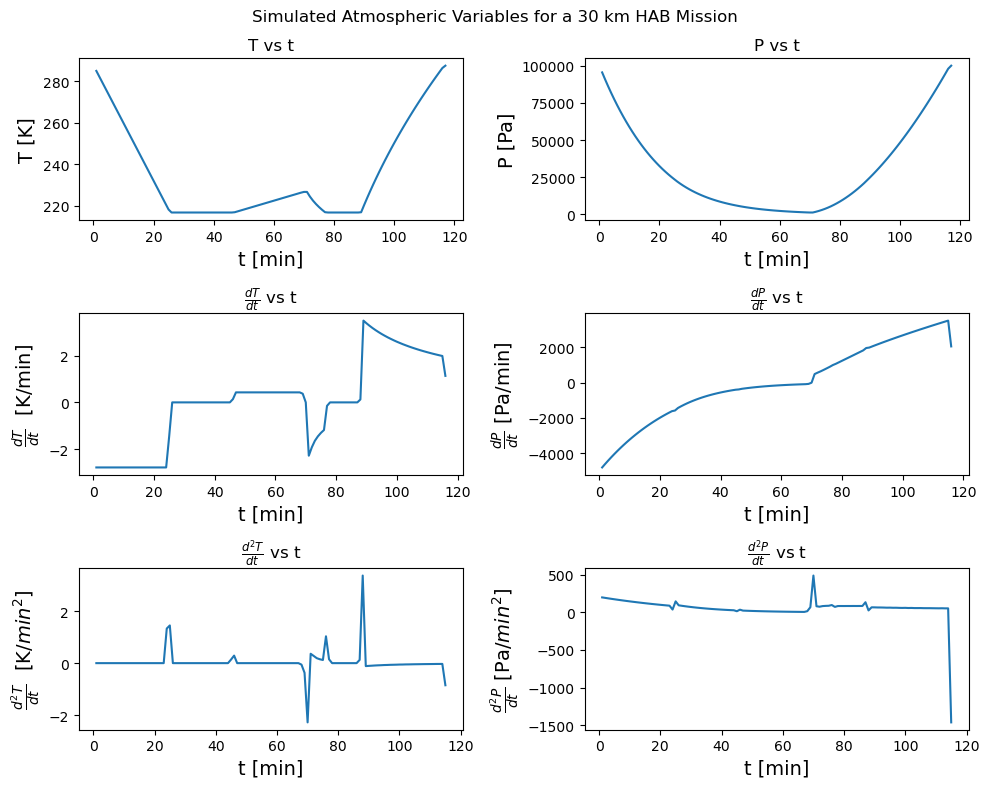


Datos: Frigorífico
--------------------------------
|     Variable       |  Valor  |
--------------------------------
|   min_T    [K]    |  216.65  |
|   prom_T   [K]    |  235.14  |
|   max_T    [K]    |  287.45  |
|   dT_min   [K]    |  -2.78   |
|   dT_prom  [K]    |  0.02    |
|   dT_max   [K]    |  3.50    |
--------------------------------


Datos: Cámara de vacío
-----------------------------------
|     Variable      |    Valor    |
-----------------------------------
|   min_P    [Pa]  |  1200.53     |
|   prom_P   [Pa]  |  30017.67    |
|   max_P    [Pa]  |  100044.18   |
|   dP_min   [Pa]  |  -4803.28    |
|   dP_prom  [Pa]  |  39.01       |
|   dP_max   [Pa]  |  3518.57     |
-----------------------------------


In [7]:
# Fecha y Hora
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("_%Y-%m-%d_%H-%M-%S")

# Cargar archivo CSV de: https://predict.sondehub.org
Data = data_upload()
sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3 = calculus(Data)
lapse_rate=[sim_temperature,sim_time]

#Graphics
graphics1(formatted_datetime,sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3)
graphics2(formatted_datetime,sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3)

#Tabla resumen
tabla_resumen(sim_temperature,sim_pressure)

    